In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve


Mounted at /content/drive


In [ ]:
# Define the input and output directories
input_dir = '/content/drive/MyDrive/CNN Minor/Train_G_Data'
mask_dir = '/content/drive/MyDrive/CNN Minor/Grayscale_Mask'
output_dir = '/content/drive/MyDrive/CNN Minor/Saliency_Models'


In [ ]:
# Define the desired dimensions for the images
img_size = (256, 256)

# Load the dataset of images and their corresponding segmentation masks
X = []
y = []
for filename in os.listdir(input_dir):
    # Load the image and its mask
    img = Image.open(os.path.join(input_dir, filename))
    mask_filename = filename.split('.')[0] + '_mask.png'
    mask = Image.open(os.path.join(mask_dir, mask_filename))

    # Convert the images to numpy arrays
    img_arr = np.array(img).reshape((1, img_size[0], img_size[1], 1)) / 255.0
    mask_arr = np.array(mask).reshape((1, img_size[0], img_size[1], 1))

    # Append the image and mask arrays to X and y
    X.append(img_arr)
    y.append(mask_arr)

# Convert X and y to numpy arraysw
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)



# **ResNet**

# **Basic U-net**

In [ ]:
# Define the UNet architecture
inputs = tf.keras.layers.Input(shape=(img_size[0], img_size[1], 1))

conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = tf.keras.layers.Dropout(0.5)(conv4)
up5 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop4)
merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)

conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)

conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

# Output
outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

# Define the model
unet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=50)

unet_model.save(os.path.join(output_dir, 'Unet_Classifier_2.h5'))

# **U-Net with early stopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the UNet architecture
inputs = tf.keras.layers.Input(shape=(img_size[0], img_size[1], 1))

conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = tf.keras.layers.Dropout(0.5)(conv4)
up5 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop4)
merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)

conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)

conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

# Output
outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

# Define the model
unet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with early stopping
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=40, callbacks=[early_stop])

# Save the model and history
unet_model.save(os.path.join(output_dir, 'Unet_es.h5'))
np.save(os.path.join(output_dir, 'Unet_es_history.npy'), history.history)

Epoch 1/40
32/32 [==============================] - 41s 494ms/step - loss: 0.1899 - accuracy: 0.9437 - val_loss: 0.1551 - val_accuracy: 0.9633
Epoch 2/40
32/32 [==============================] - 16s 496ms/step - loss: 0.1464 - accuracy: 0.9654 - val_loss: 0.1471 - val_accuracy: 0.9633
Epoch 3/40
32/32 [==============================] - 16s 489ms/step - loss: 0.1404 - accuracy: 0.9654 - val_loss: 0.1436 - val_accuracy: 0.9633
Epoch 4/40
32/32 [==============================] - 16s 505ms/step - loss: 0.1244 - accuracy: 0.9652 - val_loss: 0.1140 - val_accuracy: 0.9633
Epoch 5/40
32/32 [==============================] - 16s 507ms/step - loss: 0.1221 - accuracy: 0.9642 - val_loss: 0.1260 - val_accuracy: 0.9633
Epoch 6/40
32/32 [==============================] - 16s 499ms/step - loss: 0.1089 - accuracy: 0.9654 - val_loss: 0.1008 - val_accuracy: 0.9633
Epoch 7/40
32/32 [==============================] - 16s 512ms/step - loss: 0.1099 - accuracy: 0.9689 - val_loss: 0.1581 - val_accuracy: 0.9633

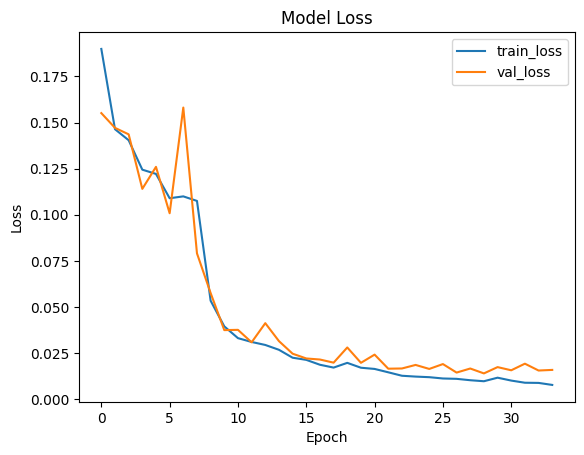

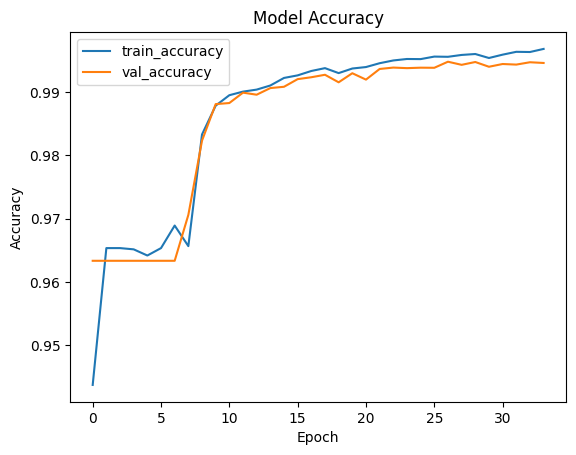

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model = load_model('/content/drive/MyDrive/CNN Minor/Saliency_Models/Unet_es.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# **SegNet**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os

# Define the input shape
input_shape = (256, 256, 1)

# Define the input layer
inputs = Input(shape=input_shape)

# Define the encoder layers
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool2 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
pool3 = MaxPooling2D((2, 2))(conv7)
conv8 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

# Define the decoder layers
up1 = UpSampling2D((2, 2))(conv8)
conv9 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
conv10 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv9)
conv11 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv10)
up2 = UpSampling2D((2, 2))(conv11)
conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv12)
up3 = UpSampling2D((2, 2))(conv13)
conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
conv15 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv14)

# Define the output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv15)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=40, callbacks=[early_stop])

# Save the model and history
model.save(os.path.join(output_dir, 'SegNet_Classifier.h5'))
np.save(os.path.join(output_dir, 'history.npy'), history.history)

Epoch 1/40
32/32 [==============================] - 18s 392ms/step - loss: 0.4506 - accuracy: 0.9653 - val_loss: 0.1536 - val_accuracy: 0.9633
Epoch 2/40
32/32 [==============================] - 13s 395ms/step - loss: 0.1481 - accuracy: 0.9654 - val_loss: 0.1500 - val_accuracy: 0.9633
Epoch 3/40
32/32 [==============================] - 13s 395ms/step - loss: 0.1431 - accuracy: 0.9654 - val_loss: 0.1493 - val_accuracy: 0.9633
Epoch 4/40
32/32 [==============================] - 13s 397ms/step - loss: 0.1416 - accuracy: 0.9654 - val_loss: 0.1471 - val_accuracy: 0.9633
Epoch 5/40
32/32 [==============================] - 13s 399ms/step - loss: 0.1409 - accuracy: 0.9654 - val_loss: 0.1468 - val_accuracy: 0.9633
Epoch 6/40
32/32 [==============================] - 13s 402ms/step - loss: 0.1413 - accuracy: 0.9654 - val_loss: 0.1471 - val_accuracy: 0.9633
Epoch 7/40
32/32 [==============================] - 13s 392ms/step - loss: 0.1417 - accuracy: 0.9654 - val_loss: 0.1465 - val_accuracy: 0.9633

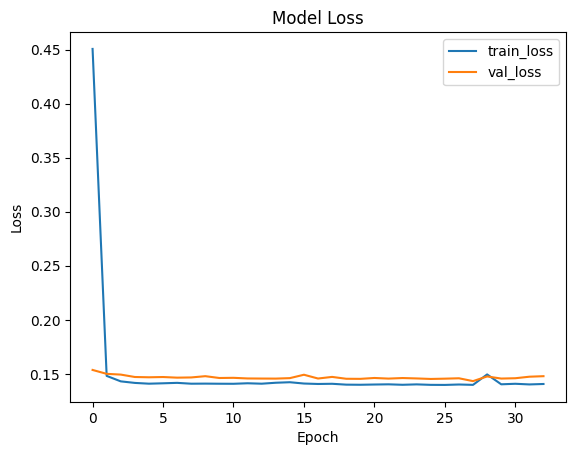

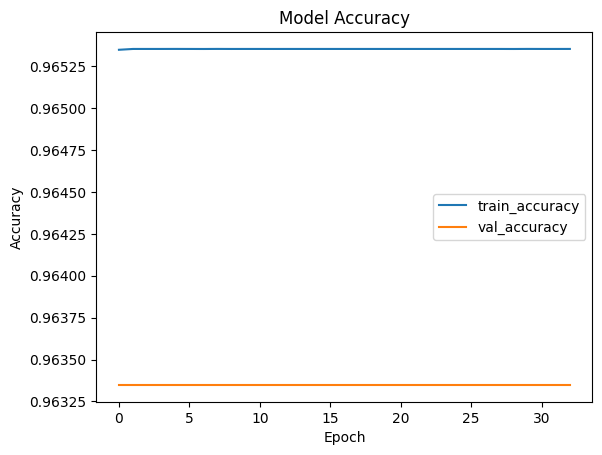

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# **ResNet**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os

# Define the input shape
input_shape = (256, 256, 1)

# Define the input layer
inputs = Input(shape=input_shape)

# Define the encoder layers
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D((2, 2))(drop4)

# Define the decoder layers
up1 = UpSampling2D((2, 2))(pool4)
up1 = Concatenate()([up1, drop4])
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
up2 = Concatenate()([up2, conv3])
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
up3 = Concatenate()([up3, conv2])
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

up4 = UpSampling2D((2, 2))(conv7)
up4 = Concatenate()([up4, conv1])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

# Define the output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=40, callbacks=[early_stop])

# Save the model and history
model.save(os.path.join(output_dir, 'ResNet.h5'))
np.save(os.path.join(output_dir, 'ResNet_history.npy'), history.history)

Epoch 1/40
32/32 [==============================] - 25s 435ms/step - loss: 0.3099 - accuracy: 0.9359 - val_loss: 0.1585 - val_accuracy: 0.9633
Epoch 2/40
32/32 [==============================] - 14s 428ms/step - loss: 0.1491 - accuracy: 0.9654 - val_loss: 0.1507 - val_accuracy: 0.9633
Epoch 3/40
32/32 [==============================] - 14s 431ms/step - loss: 0.1443 - accuracy: 0.9654 - val_loss: 0.1458 - val_accuracy: 0.9633
Epoch 4/40
32/32 [==============================] - 13s 419ms/step - loss: 0.1385 - accuracy: 0.9654 - val_loss: 0.1516 - val_accuracy: 0.9633
Epoch 5/40
32/32 [==============================] - 14s 423ms/step - loss: 0.1387 - accuracy: 0.9654 - val_loss: 0.1485 - val_accuracy: 0.9633
Epoch 6/40
32/32 [==============================] - 14s 442ms/step - loss: 0.1264 - accuracy: 0.9654 - val_loss: 0.1240 - val_accuracy: 0.9633
Epoch 7/40
32/32 [==============================] - 14s 431ms/step - loss: 0.1187 - accuracy: 0.9638 - val_loss: 0.1483 - val_accuracy: 0.9633

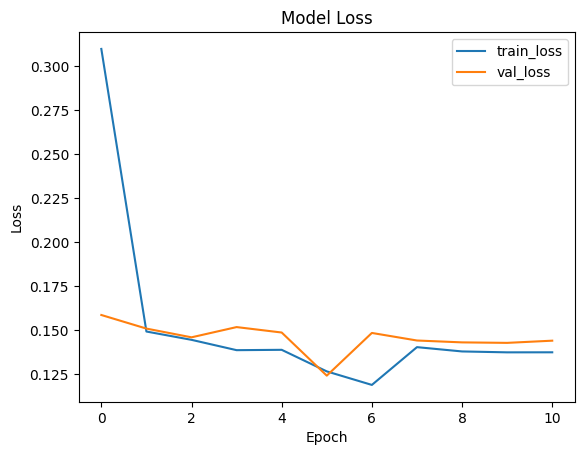

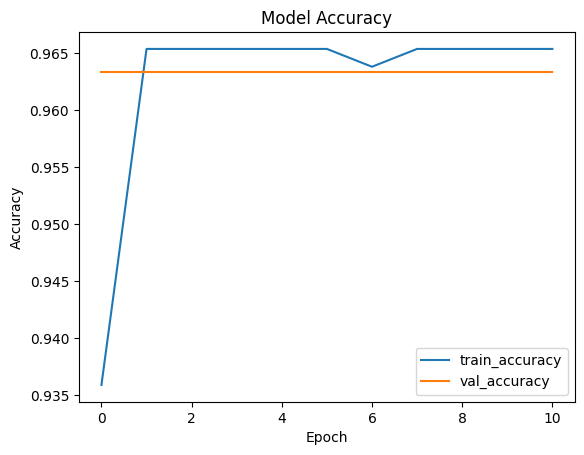

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# **Results Analysis/F1-Score for all Test Images**

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

model = load_model('/content/drive/MyDrive/CNN Minor/Saliency_Models/Unet_Classifier_2.h5')

test_dir = '/content/drive/MyDrive/CNN Minor/Test_G_Data/'
mask_dir = '/content/drive/MyDrive/CNN Minor/Grayscale_Mask/'

f1_scores = []
for filename in os.listdir(test_dir):
    if filename.endswith('.png'):
        img_path = os.path.join(test_dir, filename)
        mask_path = os.path.join(mask_dir, filename[:-4] + '_mask.png')
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        img = img.astype('float32') / 255.0

        # Generate predictions for test set
        y_pred = model.predict(img)

        # Apply threshold to obtain binary segmentation mask
        y_pred_thresh = (y_pred >= 0.5).astype(np.uint8)

        y_pred_thresh = np.squeeze(y_pred_thresh, axis=0)
        y_pred_thresh = np.squeeze(y_pred_thresh, axis=-1)

        # Convert multilabel-indicator to binary format
        mask_binary = (mask >= 0.5).astype(np.uint8)

        # Calculate F1-score
        f1score_micro = f1_score(mask_binary, y_pred_thresh, average='micro')
        print(f"Filename: {filename} F1-score (micro): {f1score_micro}")
        f1_scores.append(f1score_micro)

# Calculate average F1-score
avg_f1_score = sum(f1_scores) / len(f1_scores)
print(f"Average F1-score: {avg_f1_score}")

1/1 [==============================] - 0s 333ms/step
Filename: a0533.png F1-score (micro): 0.9561493662213085
1/1 [==============================] - 0s 31ms/step
Filename: e0747.png F1-score (micro): 0.9291983616149795
1/1 [==============================] - 0s 26ms/step
Filename: g0548.png F1-score (micro): 0.9646621202727835
1/1 [==============================] - 0s 22ms/step
Filename: a0111.png F1-score (micro): 0.9407178820854313
1/1 [==============================] - 0s 20ms/step
Filename: g0321.png F1-score (micro): 0.9206061976928296
1/1 [==============================] - 0s 19ms/step
Filename: a0333.png F1-score (micro): 0.9527177472167648
1/1 [==============================] - 0s 22ms/step
Filename: a0226.png F1-score (micro): 0.9382617382617383
1/1 [==============================] - 0s 21ms/step
Filename: a0216.png F1-score (micro): 0.9420737992166563
1/1 [==============================] - 0s 26ms/step
Filename: e070.png F1-score (micro): 0.9659461981029389
1/1 [==============

1/1 [==============================] - 0s 20ms/step
Classification Report:
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   6316768
  Foreground       0.95      0.93      0.94    236832

    accuracy                           1.00   6553600
   macro avg       0.97      0.97      0.97   6553600
weighted avg       1.00      1.00      1.00   6553600

Confusion Matrix:
[[0.99798726 0.00201274]
 [0.06599193 0.93400807]]


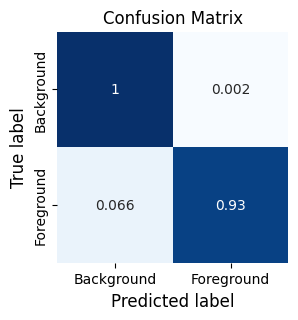

Precision: 0.9456
Recall: 0.9340
F1-Score: 0.9398


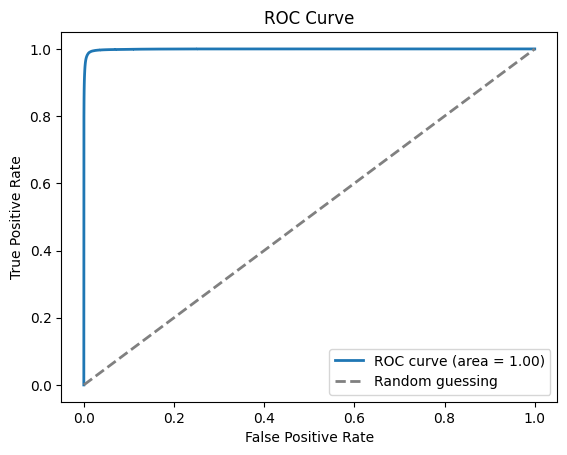

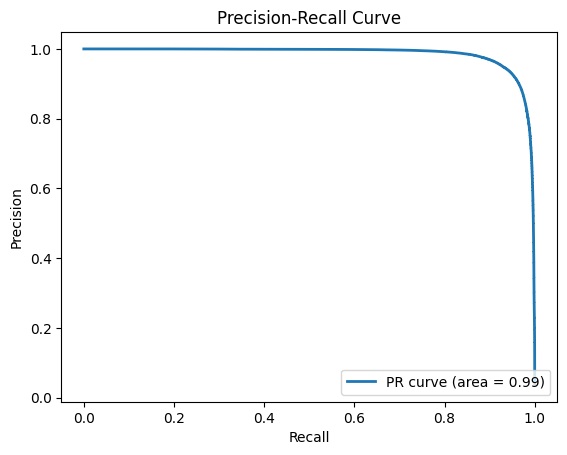

In [ ]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

model = load_model('/content/drive/MyDrive/CNN Minor/Saliency_Models/Unet_Classifier_2.h5')

test_dir = '/content/drive/MyDrive/CNN Minor/Test_G_Data/'
mask_dir = '/content/drive/MyDrive/CNN Minor/Grayscale_Mask/'

classes = ['Background', 'Foreground']  # Define class names for binary segmentation

y_true = []  # Ground truth labels
y_pred = []  # Predicted labels
y_pred_single = [] # Predicted scores

for filename in os.listdir(test_dir):
    if filename.endswith('.png'):
        img_path = os.path.join(test_dir, filename)
        mask_path = os.path.join(mask_dir, filename[:-4] + '_mask.png')
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        img = img.astype('float32') / 255.0

        # Generate predictions for test set
        y_pred_batch = model.predict(img)
        y_pred_single_batch = y_pred_batch.flatten()
        y_pred_binary_batch = (y_pred_batch >= 0.5).astype(np.uint8)

        # Apply threshold to obtain binary segmentation mask
        y_pred_thresh = np.squeeze(y_pred_binary_batch, axis=0)
        y_pred_thresh = np.squeeze(y_pred_thresh, axis=-1)

        # Convert multilabel-indicator to binary format
        mask_binary = (mask >= 0.5).astype(np.uint8)

        # Append ground truth and predicted labels and scores
        y_true.extend(mask_binary.flatten())
        y_pred.extend(y_pred_thresh.flatten())
        y_pred_single.extend(y_pred_single_batch)


# Calculate precision, recall, F1-score and support
precision, recall, f1_score, support = \
classification_report(y_true, y_pred, target_names=classes, output_dict=True)['Foreground'].values()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Print binary confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, normalize='true')
print(cm)

# Plot the confusion matrix heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

# Print precision, recall and F1-score
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_single)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_single)
avg_precision = auc(recall, precision)
plt.plot(recall, precision, lw=2, label='PR curve (area = %0.2f)' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# **F1-Score for Sample Test Images**

In [ ]:
# a061.png-> image without inline expression
# a051.png-> image with inline expression


import cv2
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/CNN Minor/Saliency_Models/ResNet.h5')

img = cv2.imread('/content/drive/MyDrive/CNN Minor/Grayscale_256/a061.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('/content/drive/MyDrive/CNN Minor/Grayscale_Mask/a061_mask.png', cv2.IMREAD_GRAYSCALE)

img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)
img = img.astype('float32') / 255.0

# Generate predictions for test set
y_pred = model.predict(img)

# Apply threshold to obtain binary segmentation mask
y_pred_thresh = (y_pred >= 0.5).astype(np.uint8)

y_pred_thresh = np.squeeze(y_pred_thresh, axis=0)
y_pred_thresh = np.squeeze(y_pred_thresh, axis=-1)

print(y_pred_thresh.shape)
print(mask.shape)

# Convert multilabel-indicator to binary format
mask_binary = (mask >= 0.4).astype(np.uint8)

# Calculate F1-score
from sklearn.metrics import f1_score


# Compute F1 score with 'micro' averaging
f1_micro = f1_score(mask_binary, y_pred_thresh, average='micro')

# Compute F1 score with 'macro' averaging
f1_macro = f1_score(mask_binary, y_pred_thresh, average='macro')

# Compute F1 score with 'weighted' averaging
f1_weighted = f1_score(mask_binary, y_pred_thresh, average='weighted')

# Print the F1 scores for each averaging method

print("F1 score (micro):", f1_micro)
print("F1 score (macro):", f1_macro)
print("F1 score (weighted):", f1_weighted)





1/1 [==============================] - 0s 480ms/step
(256, 256)
(256, 256)
F1 score (micro): 0.0
F1 score (macro): 0.0
F1 score (weighted): 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


# **Saleincy Map**

1/1 [==============================] - 1s 664ms/step


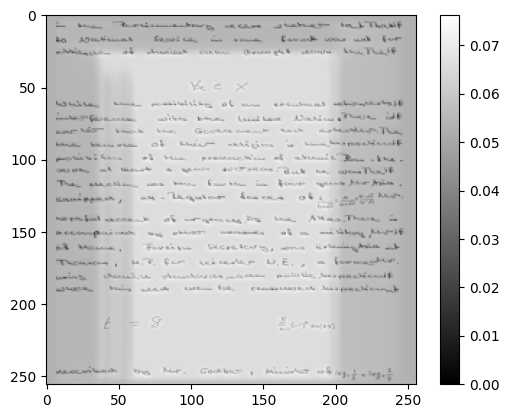

In [ ]:

import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('/content/drive/MyDrive/CNN Minor/Saliency_Models/ResNet.h5')

img = cv2.imread('/content/drive/MyDrive/CNN Minor/Grayscale_256/a051.png', cv2.IMREAD_GRAYSCALE)

img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)
img = img.astype('float32') / 255.0

# Generate predictions for test set
saliency_map = model.predict(img)

saliency_map = np.squeeze(saliency_map, axis=0)
saliency_map = np.squeeze(saliency_map, axis=-1)

# visualize the saliency map
# plt.imshow(saliency_map)

# Assuming you have computed the saliency map for your image and stored it in a numpy array called 'saliency_map'
# The saliency map should have the same size as the original image (256, 256)

# Load the grayscale image and convert it to a numpy array
image = plt.imread('/content/drive/MyDrive/CNN Minor/Grayscale_256/a051.png')

# Normalize the saliency map to have values between 0 and 1
# saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

# Create a heatmap using the saliency map
# Pastel1,
heatmap = plt.imshow(saliency_map, cmap='gray')

# Overlay the heatmap on the original image
overlay = plt.imshow(image, cmap='gray', alpha=0.7)

# Set the colorbar scale to match the saliency map
plt.colorbar(heatmap)

# Display the image with the heatmap overlay
plt.show()


# **Binary Mask**

In [ ]:
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

model = load_model('/content/drive/MyDrive/CNN Minor/Saliency_Models/Unet_Classifier_2.h5')

image = cv2.imread('/content/drive/MyDrive/CNN Minor/Grayscale_256/a0143.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('/content/drive/MyDrive/CNN Minor/Grayscale_Mask/a0143_mask.png', cv2.IMREAD_GRAYSCALE)

image = np.expand_dims(image, axis=-1)
image = np.expand_dims(image, axis=0)
image = image.astype('float32') / 255.0

# Generate predictions for test set
saliency_map = model.predict(image)

saliency_map = np.squeeze(saliency_map, axis=0)
saliency_map = np.squeeze(saliency_map, axis=-1)

threshold=0.5

binary_mask = np.zeros_like(saliency_map)
binary_mask[saliency_map >= threshold] = 255

binary_mask = binary_mask.astype(np.uint8)

print(image.shape)
print(saliency_map.shape)
print(binary_mask.shape)


1/1 [==============================] - 0s 288ms/step
(1, 256, 256, 1)
(256, 256)
(256, 256)


# **Localization**

['98,157,143,170', '98,97,143,109']


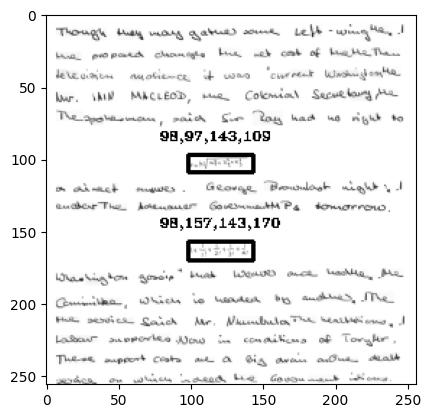

In [ ]:
image = cv2.imread('/content/drive/MyDrive/CNN Minor/Grayscale_256/a0143.png', cv2.IMREAD_GRAYSCALE)

# Find all contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

locations=[]

# Iterate over contours
for contour in contours:
    # Get the bounding box coordinates of the contour
    x, y, w, h = cv2.boundingRect(contour)
    x2, y2 = x+w, y+h

    # Draw the bounding box on the original image
    cv2.rectangle(image, (x, y), (x2, y2), (0, 255, 255), 2)

    # Get the location of the contour in the format you specified
    location = f'{x},{y},{x2},{y2}'

     # Calculate the position of the text
    text_position = (x-20, y-10)

    # Check if the text position goes out of the left boundary of the image
    if text_position[0] < 0:
        text_position = (0, y2+10)

    # Check if the text position goes out of the right boundary of the image
    elif text_position[0] + w > image.shape[1]:
        text_position = (image.shape[1]-w, y2+10)

    # Check if the text position goes out of the top boundary of the image
    if text_position[1] < 0:
        text_position = (text_position[0], y2+10)

    # Check if the text position goes out of the bottom boundary of the image
    elif text_position[1] + h > image.shape[0]:
        text_position = (text_position[0], y-10-h)


    # Write the location beside the bounding box
    cv2.putText(image, location, text_position, cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0, 255, 0), 1)

    locations.append(location)

sorted_locations = sorted(locations, key=lambda x: int(x[1]), reverse=True)

print(sorted_locations)

# Display the result
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Convert the OpenCV image to Matplotlib format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result using Matplotlib
plt.imshow(image)
plt.show()
